Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null
#!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > -d "/content/drive/MyDrive/"

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")



In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

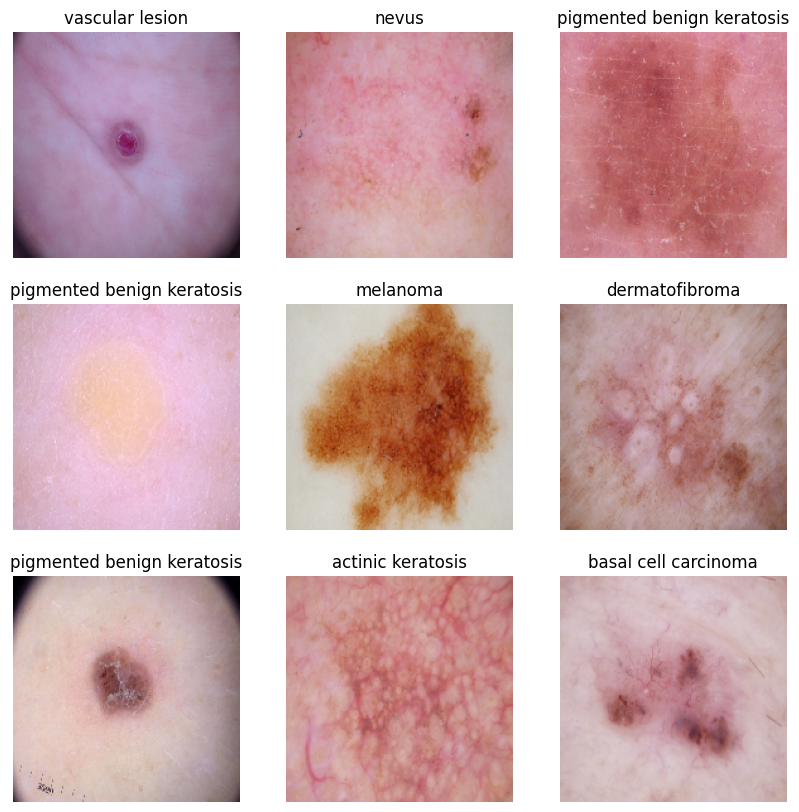

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here

# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [16]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 70ms/step - loss: 2.0451 - accuracy: 0.2684 - val_loss: 1.7613 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7014 - accuracy: 0.3717 - val_loss: 1.5862 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5499 - accuracy: 0.4459 - val_loss: 1.4523 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4330 - accuracy: 0.4944 - val_loss: 1.4349 - val_accuracy: 0.5481
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3196 - accuracy: 0.5379 - val_loss: 1.4946 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2380 - accuracy: 0.5508 - val_loss: 1.4638 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.2075 - accuracy: 0.5887 - val_loss: 1.4082 - val_accuracy: 0.5101
Epoch 8/20
5

### Visualizing training results

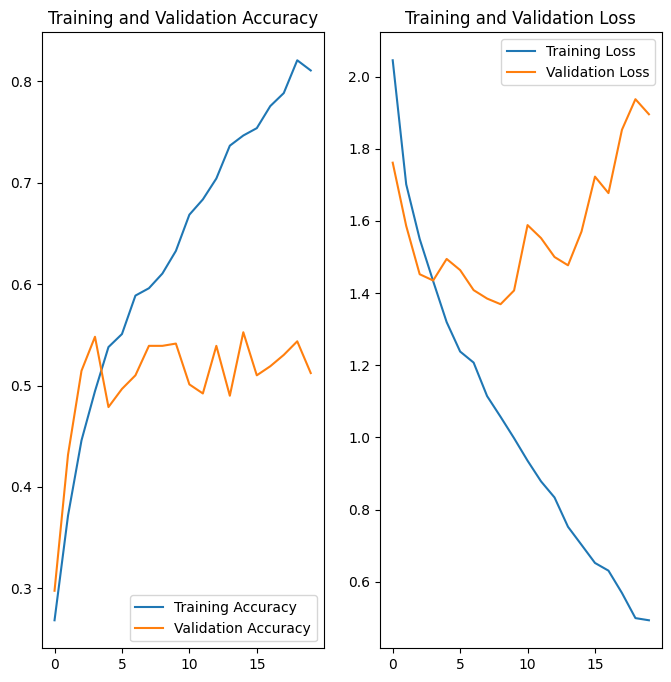

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

***Observations:***

1. The model's training accuracy shows a steady increase of upto 81%, while validation accuracy remains consistently around 51%.

2. A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

3. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

In [18]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

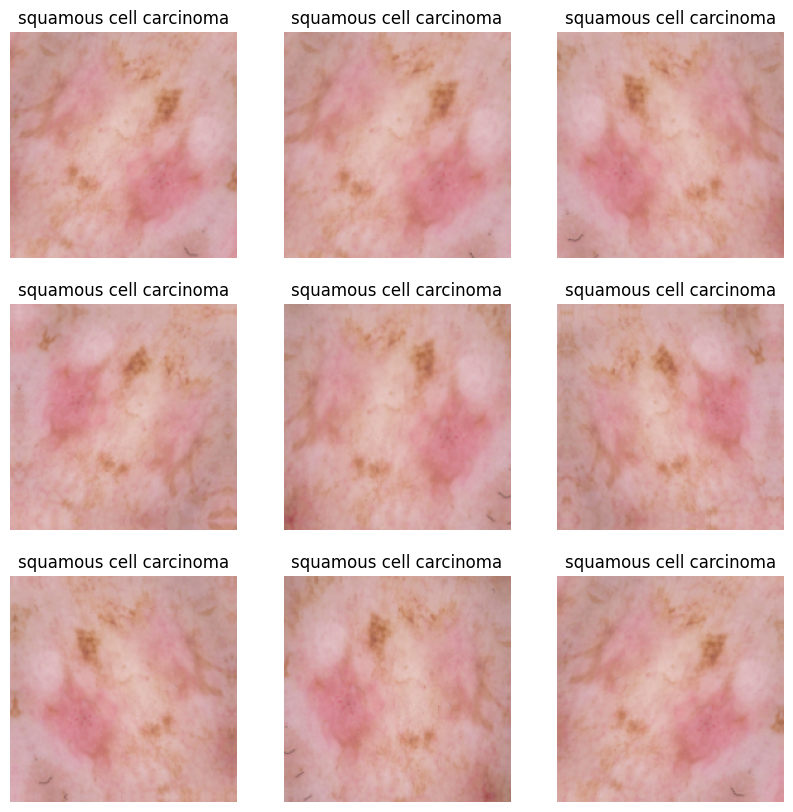

In [19]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compiling the model

In [21]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 33ms/step - loss: 1.9125 - accuracy: 0.2952 - val_loss: 1.8403 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6170 - accuracy: 0.4202 - val_loss: 1.5666 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4673 - accuracy: 0.4721 - val_loss: 1.4158 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4003 - accuracy: 0.5011 - val_loss: 1.3765 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3733 - accuracy: 0.5089 - val_loss: 1.3757 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3150 - accuracy: 0.5324 - val_loss: 1.3414 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2926 - accuracy: 0.5480 - val_loss: 1.3356 - val_accuracy: 0.5369
Epoch 8/20
56

### Visualizing the results

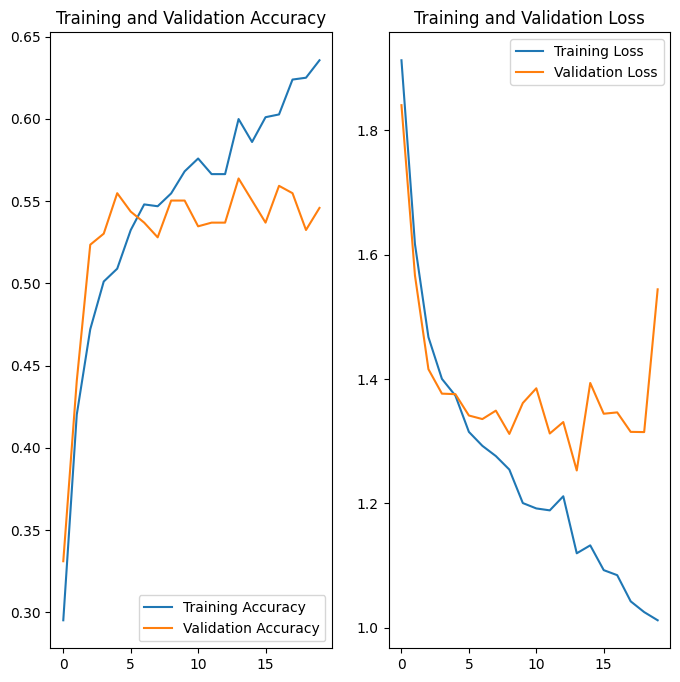

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Observations:***

1. By leveraging augmented data, overfitting has been effectively addressed.

2. The training and validation accuracy of the aforementioned model fall within a similar range.

3. Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [25]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0001157.jpg', 'melanoma'), ('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000548.jpg', 'melanoma'), ('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010366.jpg', 'melanoma'), ('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010898.jpg', 'melanoma'), ('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0001116.jpg', 'melanoma')]


In [26]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/Skin cancer ISIC The International Sk...,melanoma
1,/content/Skin cancer ISIC The International Sk...,melanoma
2,/content/Skin cancer ISIC The International Sk...,melanoma
3,/content/Skin cancer ISIC The International Sk...,melanoma
4,/content/Skin cancer ISIC The International Sk...,melanoma


In [27]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

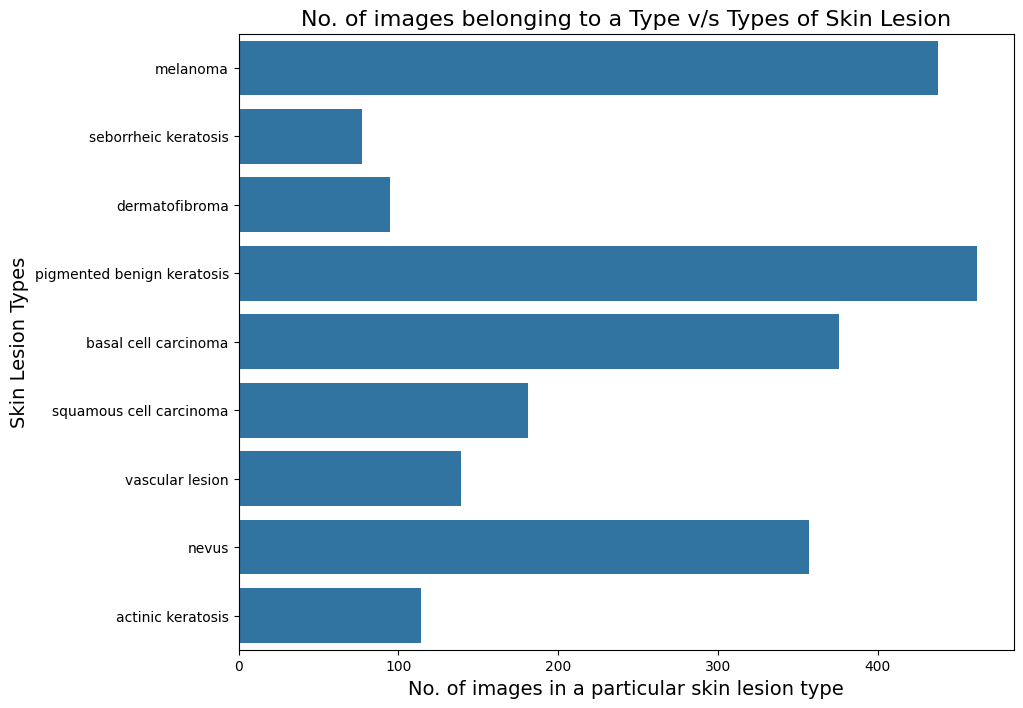

In [28]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [29]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64

#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78DCF01F0940>: 100%|██████████| 500/500 [00:21<00:00, 23.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78DC80058E80>: 100%|██████████| 500/500 [00:19<00:00, 25.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78DC801F1FF0>: 100%|██████████| 500/500 [00:21<00:00, 23.75 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=962x645 at 0x78DC2FFD1630>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78DBDC7039A0>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78DBDC71B520>: 100%|██████████| 500/500 [00:16<00:00, 30.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78DC8D444FA0>: 100%|██████████| 500/500 [00:38<00:00, 13.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78DC801F0C40>: 100%|██████████| 500/500 [00:15<00:00, 31.32 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78DC2FF708E0>: 100%|██████████| 500/500 [00:15<00:00, 31.40 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010385.jpg_aef39564-ac06-4984-b74d-d7599201aa69.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009989.jpg_8c569311-d60a-4a63-a585-242e48e7f64c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010789.jpg_dc7c0be7-1037-4263-8af4-5b71af1efebe.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000414.jpg_5164adce-a34d-4e91-bf9a-943d0a6f0d40.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009868.jpg_9760a912-d165-4af1-90a0-c66efca7327f.jpg']

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Image Path', 'Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [38]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,/content/Skin cancer ISIC The International Sk...,melanoma
1,/content/Skin cancer ISIC The International Sk...,melanoma
2,/content/Skin cancer ISIC The International Sk...,melanoma
3,/content/Skin cancer ISIC The International Sk...,melanoma
4,/content/Skin cancer ISIC The International Sk...,melanoma


In [39]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [40]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [42]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [44]:
## your code goes here

model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [46]:
%%time
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 32s 171ms/step - loss: 2.3099 - accuracy: 0.3290 - val_loss: 12.2306 - val_accuracy: 0.1225
Epoch 2/30
169/169 [==============================] - 29s 166ms/step - loss: 1.5422 - accuracy: 0.4188 - val_loss: 6.6371 - val_accuracy: 0.1752
Epoch 3/30
169/169 [==============================] - 28s 163ms/step - loss: 1.4428 - accuracy: 0.4318 - val_loss: 1.5284 - val_accuracy: 0.4677
Epoch 4/30
169/169 [==============================] - 28s 163ms/step - loss: 1.3854 - accuracy: 0.4646 - val_loss: 1.2761 - val_accuracy: 0.5152
Epoch 5/30
169/169 [==============================] - 28s 162ms/step - loss: 1.3028 - accuracy: 0.4959 - val_loss: 1.3923 - val_accuracy: 0.4952
Epoch 6/30
169/169 [==============================] - 28s 160ms/step - loss: 1.2624 - accuracy: 0.5080 - val_loss: 1.2816 - val_accuracy: 0.5494
Epoch 7/30
169/169 [==============================] - 28s 162ms/step - loss: 1.2362 - accuracy: 0.5141 - val_loss: 1.4672 - val_a

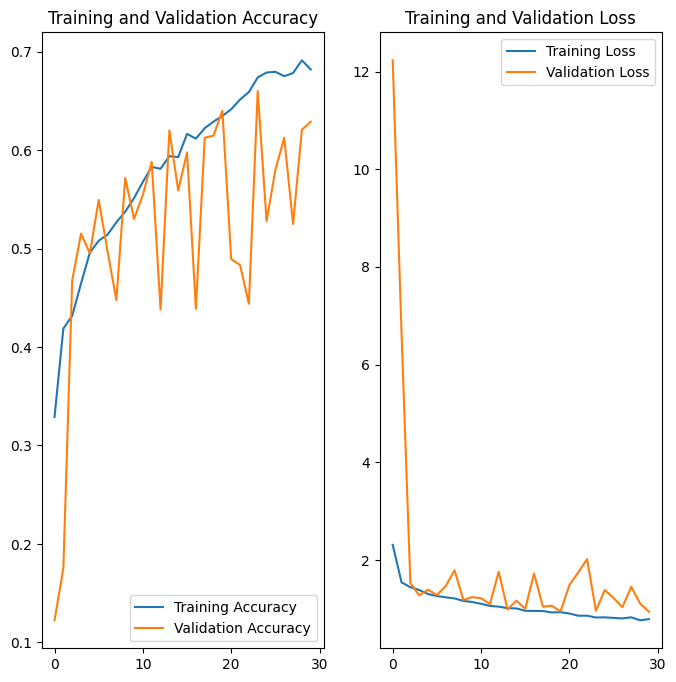

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observations:***

1. Implementing batch normalization in the model yielded a slight uptick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

#### Creating another model (without batch normalization)

In [48]:
# create the model
model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### Training the model

In [50]:
%%time
# train the model
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/60
167/169 [============================>.] - ETA: 0s - loss: 1.7276 - accuracy: 0.3316
Epoch 1: val_accuracy improved from -inf to 0.37342, saving model to model.keras
169/169 [==============================] - 30s 156ms/step - loss: 1.7251 - accuracy: 0.3335 - val_loss: 1.5818 - val_accuracy: 0.3734
Epoch 2/60
167/169 [============================>.] - ETA: 0s - loss: 1.4386 - accuracy: 0.4480
Epoch 2: val_accuracy improved from 0.37342 to 0.48255, saving model to model.keras
169/169 [==============================] - 27s 154ms/step - loss: 1.4380 - accuracy: 0.4484 - val_loss: 1.3563 - val_accuracy: 0.4826
Epoch 3/60
167/169 [============================>.] - ETA: 0s - loss: 1.3360 - accuracy: 0.4867
Epoch 3: val_accuracy improved from 0.48255 to 0.49740, saving model to model.keras
169/169 [==============================] - 27s 153ms/step - loss: 1.3375 - accuracy: 0.4865 - val_loss: 1.2769 - val_accuracy: 0.4974
Epoch 4/60
168/169 [============================>.] - ETA: 0s

#### Visualize the model results

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

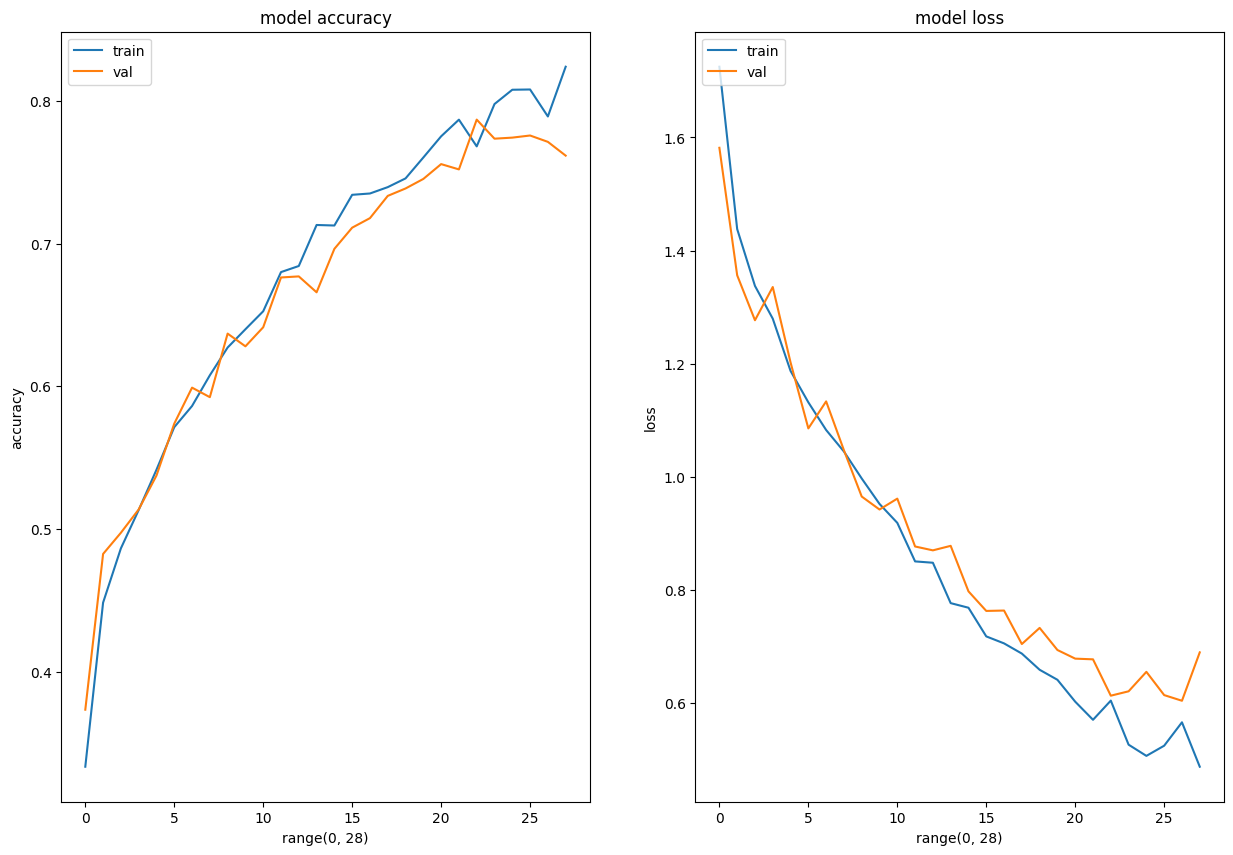

In [52]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



***Observations:***

1. The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

3. Following 28 epochs, the final model attains an accuracy of 82% on the training set and approximately 76% on the validation set.

4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

5. The addition of batch normalization failed to enhance both training and validation accuracy.

### Model Evaluation

1/1 [==============================] - 0s 304ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


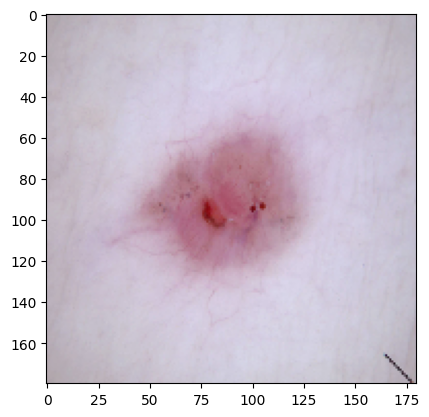

In [53]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)